In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from itertools import product

In [3]:
paths_to_performances = [
#    {
#        "annotator": "Gonzalo",
#        "window": "default",
#        "path": "resources/performance_Gonzalo_default.json"
#    },
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "path": "resources/performance_Gonzalo_abdomen.json"
    },
#    {
#        "annotator": "Maria Fernanda",
#        "window": "default",
#        "path": "resources/performance_MariaFernanda_default.json"
#    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "path": "resources/performance_MariaFernanda_abdomen.json"
    }
]

In [12]:
performances_df = pd.DataFrame()
for item in paths_to_performances:
    with open(item["path"], 'r') as file:
        results = json.load(file)
    performance = pd.DataFrame(results['bboxes'])
    performance['annotator'] = item['annotator']
    performance['window'] = item['window']
    performances_df = pd.concat([performances_df, performance])
performances_df.reset_index(inplace=True, drop=True)

In [13]:
performances_df.columns

Index(['path_to_cts', 'path_to_masks', 'path_to_output',
       'dataset_fname_relation', 'mask_fname', 'ct_fname', 'study',
       'slice_idx', 'slice_rows', 'slice_cols', 'foreground_label',
       'path_to_bbox_original', 'path_to_bbox_1024',
       'path_to_preprocessed_slice', 'bbox_original_fname', 'bbox_original',
       'bbox_1024', 'annotated_pixels', 'predicted_pixels', 'dice_score',
       'annotator', 'window'],
      dtype='object')

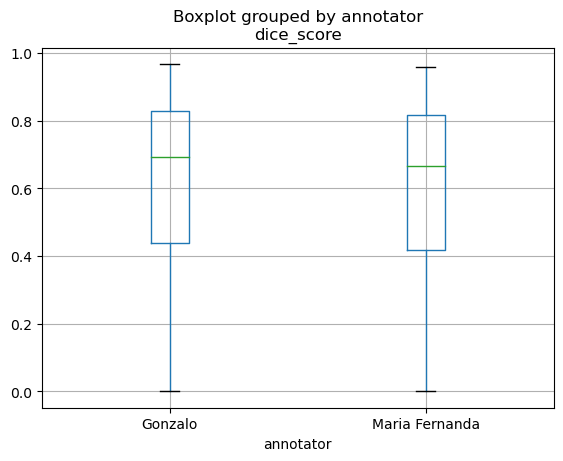

In [14]:
performances_df.boxplot(column='dice_score', by='annotator')
plt.show()

In [16]:
performances_df.groupby(['annotator', 'window']).describe()['dice_score']

,,count,mean,std,min,25%,50%,75%,max
annotator,window,,,,,,,,
Gonzalo,abdomen,613.0,0.599523,0.293091,0.0,0.439560,0.692308,0.829288,0.967742
Maria Fernanda,abdomen,875.0,0.575394,0.293490,0.0,0.416876,0.665523,0.815983,0.959436


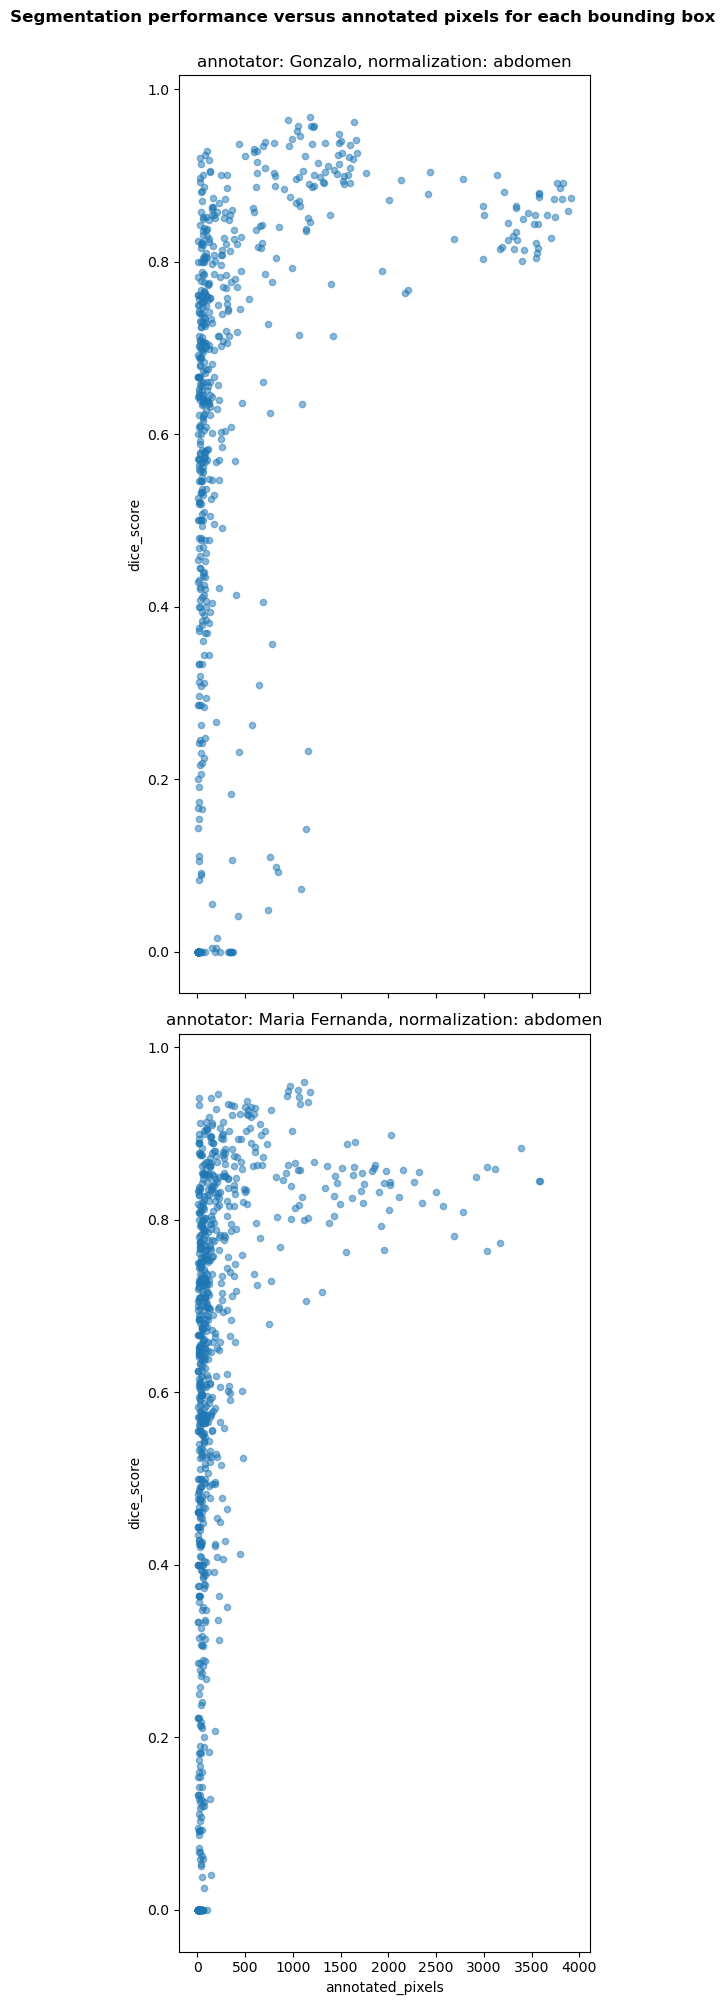

In [18]:
unique_annotators = performances_df['annotator'].unique()
unique_windows = performances_df['window'].unique()
combs = list(product(unique_annotators, unique_windows))
_, ax = plt.subplots(len(combs), 1, figsize=(5, 20), sharex=True, sharey=True)
plt.suptitle(
    "Segmentation performance versus annotated pixels for each bounding box",
    fontweight='bold',
    y=1.0
)
for idx, (annotator, window) in enumerate(combs):
    performances_df[
        (performances_df['annotator'] == annotator) &
        (performances_df['window'] == window)
    ].plot.scatter(
        x='annotated_pixels',
        y='dice_score',
        ax=ax[idx],
        alpha=0.5
    )
    ax[idx].set_title(f"annotator: {annotator}, normalization: {window}")
plt.tight_layout()
plt.show()